In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

In [2]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

In [3]:
temp = pd.read_csv('data_hrly.csv')

In [4]:
dataset = pd.read_csv('data_hrly.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

pol_avg=dataset['pollution'].mean()
pol_std=dataset['pollution'].std()
low=int(pol_avg-pol_std/2)
high=int(pol_avg+pol_std/2)
dataset['pollution']=dataset['pollution'].apply(lambda x: np.random.choice([x for x in range(low,high)]) if (np.isnan(x)) else x)

In [5]:
dataset['month'] = np.array(temp['month'])
print("** DATA PROCESSING COMPLETED **")
dataset.to_csv('pollution.csv')

** DATA PROCESSING COMPLETED **


In [6]:
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,month
date,,,,,,,,,
2010-01-01 00:00:00,128.0,-21,-11.0,1021.0,NW,1.79,0,0,1
2010-01-01 01:00:00,64.0,-21,-12.0,1020.0,NW,4.92,0,0,1
2010-01-01 02:00:00,77.0,-21,-11.0,1019.0,NW,6.71,0,0,1
2010-01-01 03:00:00,64.0,-21,-14.0,1019.0,NW,9.84,0,0,1
2010-01-01 04:00:00,97.0,-20,-12.0,1018.0,NW,12.97,0,0,1
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0,12
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0,12
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0,12


In [7]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
#Label Encoder
lbe = LabelEncoder()
# Min Max Scalar
pol_scaler = MinMaxScaler()
wea_scaler = MinMaxScaler()

In [8]:
dataset = pd.read_csv('pollution.csv',index_col='date')
dataset['wnd_dir'] = lbe.fit_transform(dataset['wnd_dir'])
pollution_data=np.array(dataset.iloc[:,0])
weather_data=np.array(dataset.drop(['pollution'],axis=1))
pollution_data =pol_scaler.fit_transform(pollution_data.reshape(-1,1))
weather_data = wea_scaler.fit_transform(weather_data)
print("Shape: ",weather_data.shape)

Shape:  (43824, 8)


In [9]:
weather_data.shape,pollution_data.shape

((43824, 8), (43824, 1))

In [10]:
cut=24*(40000//24)
y_train = pollution_data[:cut,:].reshape(-1,24,1)
X_train = weather_data[:cut,:].reshape(-1,24,8)
y_test = pollution_data[cut:,:].reshape(-1,24,1)
X_test = weather_data[cut:,:].reshape(-1,24,8)

tr_y=[]
tr_X=[]
for day,ddy in zip(y_train,X_train):
    mx=day.argmax()
    tr_y.append(day[mx])
    tr_X.append(ddy.mean(axis=0))

y_train=np.array(tr_y)
X_train=np.array(tr_X)

tst_y=[]
tst_X=[]
for day,ddy in zip(y_test,X_test):
    mx=day.argmax()
    tst_y.append(day[mx])
    tst_X.append(ddy.mean(axis=0))

y_test=np.array(tst_y)
X_test=np.array(tst_X)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1666, 8), (1666, 1), (160, 8), (160, 1))

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
clf = RandomForestRegressor(n_jobs=-1)

In [14]:
clf.fit(X_train,y_train.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [15]:
prediction=clf.predict(X_test).reshape(-1,1)

In [16]:
pred=pol_scaler.inverse_transform(prediction)

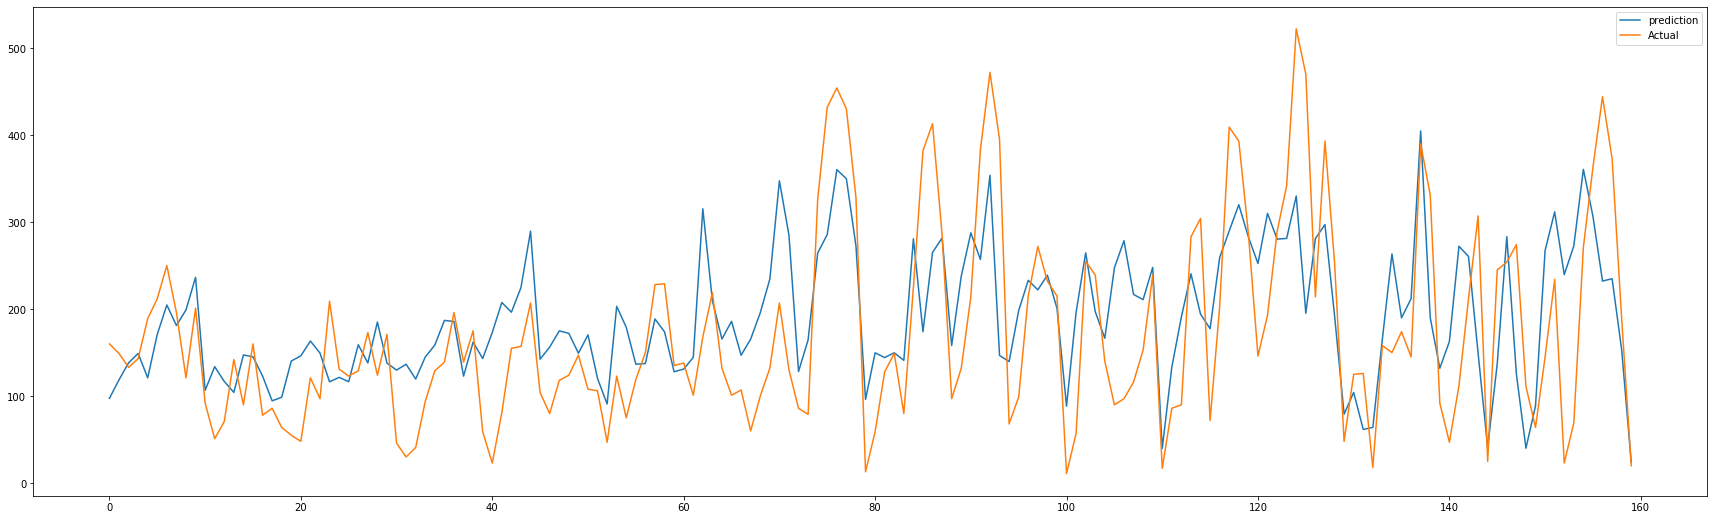

In [17]:
plt.figure(figsize=(30,9))
plt.plot(pred,label='prediction')
plt.plot(pol_scaler.inverse_transform(y_test),label='Actual')
plt.legend()
plt.show()

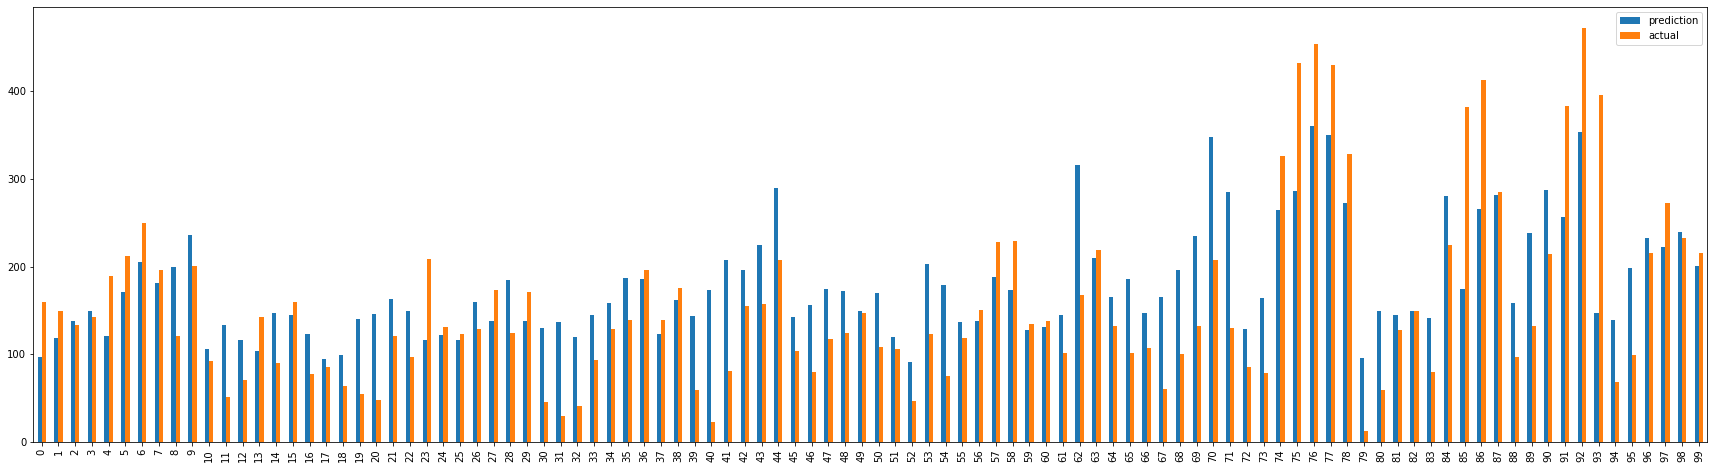

In [18]:
df=pd.DataFrame()
ll=100
df['prediction']=pred.ravel()[:ll]
df['actual']=pol_scaler.inverse_transform(y_test)[:ll]
df.plot.bar(figsize=(30,8))

In [19]:
print("Mean squared error:",(((pred-pol_scaler.inverse_transform(y_test))**2).mean())**0.5)

Mean squared error: 88.11491360362899
